<a href="https://colab.research.google.com/github/TAUforPython/denoising/blob/main/extended%20Kalman%20filter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***Реализация расширенного фильтра Калмана (EKF)***
*by Студент 3 курса РУДН Инженерной академии Габбасов Артур Азатович*


---


Я создал реализацию расширенного фильтра Калмана для примера с отслеживанием положения самолета с помощью радара, как описано в учебнике.

# Описание реализации

**Входные данные:**

1.   Измерения радара (наклонная дальность до самолета)
  *   Скалярные значения: наклонная дальность z от радара до самолёта
2.   Модель системы (нелинейные функции перехода состояния и измерений)
  *   Нелинейная функция перехода состояния
𝑓(𝑥,𝑢,𝑑𝑡)
(например, постоянная скорость, гравитация и т.п.)
  *     Нелинейная функция измерения
ℎ(𝑥) (наклонная дальность как функция от положения и высоты)
3.   Начальное состояние и ковариация
4.   Матрицы шумов процесса и измерений
  * Шум процесса 𝑄: неопределённость модели
  * Шум измерения 𝑅: погрешность радара
**Выходные данные:**

1.   Оценка состояния системы (горизонтальное положение и высота самолета)
2.   Матрица ковариации оценки состояния
  * 𝑃𝑘: отражает доверие к текущей оценке

**Ключевые особенности реализации:**

1.   Используется нелинейная модель для предсказания состояния `(f(x))` и измерений `(h(x))`
2.   На каждом шаге вычисляются якобианы этих функций для линеаризации
3.   Основные уравнения EKF реализованы в методах `predict()` и `update()`


---



In [4]:
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt, exp
import random

class ExtendedKalmanFilter:
    """
    Реализация расширенного фильтра Калмана (EKF) для нелинейных систем.
    """

    def __init__(self, dim_x, dim_z):
        """
        Инициализация EKF

        Параметры:
        dim_x - размерность вектора состояния
        dim_z - размерность вектора измерений
        """
        self.dim_x = dim_x
        self.dim_z = dim_z

        # Инициализация матриц
        self.x = np.zeros((dim_x, 1))      # Вектор состояния
        self.P = np.eye(dim_x)             # Матрица ковариации состояния
        self.Q = np.eye(dim_x)             # Матрица шума процесса
        self.R = np.eye(dim_z)             # Матрица шума измерений
        self.F = np.eye(dim_x)             # Матрица перехода состояния
        self.H = np.zeros((dim_z, dim_x))  # Матрица измерений

    def predict(self, f, F_jacobian, u=None, dt=None):
        """
        Этап предсказания EKF

        Параметры:
        f - нелинейная функция перехода состояния f(x, u, dt)
        F_jacobian - функция, возвращающая якобиан f(x, u, dt)
        u - вектор управления (опционально)
        dt - временной шаг (опционально)
        """
        # Предсказание состояния через нелинейную функцию
        self.x = f(self.x, u, dt)

        # Линеаризация - вычисление якобиана F
        self.F = F_jacobian(self.x, u, dt)

        # Предсказание ковариации
        self.P = self.F @ self.P @ self.F.T + self.Q

    def update(self, z, h, H_jacobian):
        """
        Этап обновления EKF

        Параметры:
        z - вектор измерений
        h - нелинейная функция измерений h(x)
        H_jacobian - функция, возвращающая якобиан h(x)
        """
        # Линеаризация - вычисление якобиана H
        self.H = H_jacobian(self.x)

        # Предсказание измерения
        z_pred = h(self.x)

        # Инновация (разница между измерением и предсказанием)
        y = z - z_pred

        # Ковариация инновации
        S = self.H @ self.P @ self.H.T + self.R

        # Оптимальная калмановская gain
        K = self.P @ self.H.T @ np.linalg.inv(S)

        # Обновление оценки состояния
        self.x = self.x + K @ y

        # Обновление ковариации
        I = np.eye(self.dim_x)
        self.P = (I - K @ self.H) @ self.P


In [7]:
    # Инициализация параметров
    dt = 0.1  # временной шаг
    t = np.arange(0, 100, dt)  # временная шкала

    # Истинная траектория самолета (горизонтальное положение и высота)
    true_pos = 1000 + 50*t  # линейное движение
    true_alt = 1000 + 10*np.sin(0.1*t)  # небольшие колебания высоты

    # Модель радара
    class Radar:
        def __init__(self):
            self.pos_noise = 10  # шум положения
            self.alt_noise = 5   # шум высоты

        def measure(self, pos, alt):
            # Измерение наклонной дальности с шумом
            slant = sqrt(pos**2 + alt**2)
            return slant + random.gauss(0, self.pos_noise)

    radar = Radar()

    # Инициализация EKF
    ekf = ExtendedKalmanFilter(dim_x=2, dim_z=1)

    # Начальное состояние: [горизонтальное положение, высота]
    ekf.x = np.array([[1000], [1000]])

    # Начальная ковариация
    ekf.P = np.diag([100, 100])

    # Шум процесса (предполагаем небольшие изменения)
    ekf.Q = np.diag([1, 0.1])

    # Шум измерений
    ekf.R = np.array([[radar.pos_noise**2]])

    # Функция перехода состояния (предполагаем постоянную скорость)
    def f(x, u, dt):
        # Простая модель: x_k+1 = x_k + v*dt
        # Для простоты предполагаем, что скорость постоянна
        # В реальности нужно оценивать и скорость
        return x

    # Якобиан функции перехода состояния
    def F_jacobian(x, u, dt):
        return np.eye(2)

    # Функция измерений (наклонная дальность)
    def h(x):
        pos = x[0, 0]
        alt = x[1, 0]
        return np.array([[sqrt(pos**2 + alt**2)]])

    # Якобиан функции измерений
    def H_jacobian(x):
        pos = x[0, 0]
        alt = x[1, 0]
        denom = sqrt(pos**2 + alt**2)
        return np.array([[pos/denom, alt/denom]])

    # Симуляция
    estimates = []
    measurements = []

    for i in range(len(t)):
        # Истинное состояние
        true_state = np.array([[true_pos[i]], [true_alt[i]]])

        # Измерение
        z = radar.measure(true_pos[i], true_alt[i])
        measurements.append(z)

        # Предсказание EKF
        ekf.predict(f, F_jacobian, dt=dt)

        # Обновление EKF
        ekf.update(np.array([[z]]), h, H_jacobian)

        # Сохранение оценки
        estimates.append(ekf.x.copy())

    # Визуализация результатов
    estimates = np.array(estimates).squeeze()
    measurements = np.array(measurements)


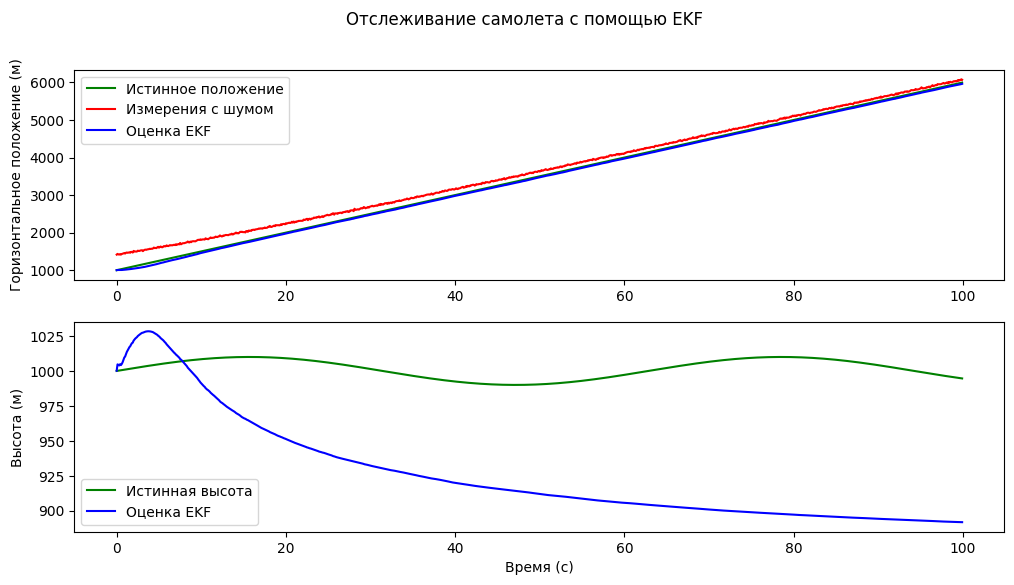

In [23]:
    plt.figure(figsize=(12, 6))

    # График горизонтального положения
    plt.subplot(2, 1, 1)
    plt.plot(t, true_pos, 'g', label='Истинное положение')
    plt.plot(t, measurements, 'r', label='Измерения с шумом')
    plt.plot(t, estimates[:, 0], 'b', label='Оценка EKF')
    plt.ylabel('Горизонтальное положение (м)')
    plt.legend()

    # График высоты
    plt.subplot(2, 1, 2)
    plt.plot(t, true_alt, 'g', label='Истинная высота')
    plt.plot(t, estimates[:, 1], 'b', label='Оценка EKF')
    plt.ylabel('Высота (м)')
    plt.xlabel('Время (с)')
    plt.legend()

    plt.suptitle('Отслеживание самолета с помощью EKF')
    plt.show()